In [1]:
%matplotlib auto

Using matplotlib backend: <object object at 0x0000020542937680>


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
from scipy.fft import fft, fftfreq
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors

In [3]:
I = np.identity(2)
sigm_z = np.array([[1., 0.], [0., -1.]])
sigm_y = np.array([[0., -1j], [1j, 0.]])
sigm_x = np.array([[0., 1.], [1., 0.]])
sigm = np.array([sigm_x, sigm_y, sigm_z])

def Uop(angvec): # Build the unitary operator from the roatation angle and vector
    ang, n = angvec[0], angvec[1:]
    U = cos(ang)*I-1j*sin(ang)*(n[0]*sigm_x +n[1]*sigm_y +n[2]*sigm_z)
    return U

def AngVec(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(0.5*np.trace(U))
    nx = 0.5j*np.trace(matmul(U, sigm_x))/sin(ang)
    ny = 0.5j*np.trace(matmul(U, sigm_y))/sin(ang)
    nz = 0.5j*np.trace(matmul(U, sigm_z))/sin(ang)
    n = real([nx, ny, nz])
    n = real( n/np.sqrt(np.sum(n*n,axis=0)))
    return np.array([real(ang), n[0], n[1], n[2]])
    
def mulAng(op2, op1): # angle of multiplied operator
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    dot = np.sum(n1*n2, axis=0)/np.sum(n1*n1, axis=0)/np.sum(n2*n2, axis=0)
    return np.arccos(cos(ang1)*cos(ang2)-dot*sin(ang1)*sin(ang2))

def mulVec(op2, op1):
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    ang = mulAng(op2, op1)
    cross21 = np.array([n2[1]*n1[2]-n2[2]*n1[1], n2[2]*n1[0]-n2[0]*n1[2], n2[0]*n1[1]-n2[1]*n1[0]])
    n = sin(ang1)*cos(ang2)*n1+sin(ang2)*cos(ang1)*n2-sin(ang1)*sin(ang2)*cross21
    n = n/sin(ang)
    return np.array([ang, n[0],n[1],n[2]])
    
#################################### This is true only for spin1/2 but it is faster!###################
def Uop2(angvec): # Build the unitary operator from the roatation angle and vector
    ang, [nx, ny, nz] = angvec
    U = np.array([[cos(ang)-1j*nz*sin(ang), -1j*nx*sin(ang)-ny*sin(ang)],
                 [-1j*nx*sin(ang)+ny*sin(ang), cos(ang)+1j*nz*sin(ang)]])
    return U

def AngVec2(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(real(U[0,0]))
    nx = -imag(U[0,1])/sin(ang)
    ny = -real(U[0,1])/sin(ang)
    nz = -imag(U[0,0])/sin(ang)
    n = real(np.array([nx, ny, nz]))
    return [real(ang), n/np.linalg.norm(n)]
############################################################################################################

In [4]:
def Hahn_echo(fL, Azz, Azx, tau, s1=1, s0=0): #Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau/2)*cos(Ome1*tau/2)-dot *sin(Ome0*tau/2)*sin(Ome1*tau/2))
    n_V0 = np.array([cos(Ome1*tau/2)*sin(Ome0*tau/2)*mx +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nx,
                     -sin(Ome1*tau/2)*sin(Ome0*tau/2)*q,
                    cos(Ome1*tau/2)*sin(Ome0*tau/2)*mz +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nz])
    n_V0 = n_V0/np.sqrt(np.sum(n_V0*n_V0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]]) 
    sigma_z = cos(mulAng(V0, V1d))
    return -np.prod(sigma_z)
def anal_HE_general(fL, Azz, Azx, tau, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2
    return -np.prod(sigma_z)
def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state


In [5]:
def DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
#     sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

def anal_DDold(fL, Azz, Azx, tau, N_pi, ms=1): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    Thet= np.arccos(cos(Ome_L*tau)*cos(Ome_h*tau)-((Ome_L+Azz)/Ome_h)*sin(Ome_L*tau)*sin(Ome_h*tau))
    sigma_z = 1-(Azx/Ome_h)**2*(1-cos(Ome_L*tau))*(1-cos(Ome_h*tau))*sin(N_pi/2*Thet)**2/(1+cos(Thet))  
    return -np.prod(sigma_z)

def just_angle_V0V1(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    theta = np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     return theta/2
    return 1- q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*(sin(N*theta/2)**2)/(cos(theta/2)**2)
#     return q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(theta))

In [6]:
def anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return signal

def ddeseem(fL, Azz, Azx, tau1, tau2, tc, N, s1=1, s0=-1): ## N must be even, Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    tau = tau1
    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 /=np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 /=np.sqrt(np.sum(n_VD1*n_VD1,axis=0))
    
    tau=tau2
    ang_WD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_WD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_WD0 /=np.sqrt(np.sum(n_WD0*n_WD0,axis=0))
    
    n_WD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_WD1 /=np.sqrt(np.sum(n_WD1*n_WD1,axis=0))
    
    
    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    WD0 = np.array([ang_WD0, n_WD0[0], n_WD0[1], n_WD0[2]])
    WD0d = np.array([ang_WD0, -n_WD0[0], -n_WD0[1], -n_WD0[2]])
    WD1 = np.array([ang_WD0, n_WD1[0], n_WD1[1], n_WD1[2]])
    WD1d = np.array([ang_WD0, -n_WD1[0], -n_WD1[1], -n_WD1[2]])
    
    VD0VD1d= mulVec(VD0, VD1d)
    WD0F0 = mulVec(WD0, F0)
    WD0F1 = mulVec(WD0, F1)
    WD1F0 = mulVec(WD1, F0)
    WD1F1 = mulVec(WD1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), np.array([WD1F0[0], -WD1F0[1], -WD1F0[2], -WD1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), np.array([WD0F0[0], -WD0F0[1], -WD0F0[2], -WD0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), np.array([WD1F1[0], -WD1F1[1], -WD1F1[2], -WD1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), np.array([WD0F1[0], -WD0F1[1], -WD0F1[2], -WD0F1[3]]))))

#     F0d = np.array([Ome0*tc/2, -mx, np.zeros_like(Azz, dtype=float), -mz])
#     F1d = np.array([Ome1*tc/2, -nx, np.zeros_like(Azz, dtype=float), -nz])
#     F0dWD1d = mulVec(F0d, WD1d)
#     F0dWD0d = mulVec(F0d, WD0d)
#     F1dWD1d = mulVec(F1d, WD1d)
#     F1dWD0d = mulVec(F1d, WD0d)
    
#     W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(WD0F0, VD0VD1d), F0dWD1d)))
#     W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(WD1F0, VD0VD1d), F0dWD0d)))
#     W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(WD0F1, VD0VD1d), F1dWD1d)))
#     W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(WD1F1, VD0VD1d), F1dWD0d)))
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)


# Let's define the nuclear spin register couplings

In [7]:
# determining the parameters
fL = 403.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=431.94493014999995 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[411.39997955 408.9316184  400.77478345 418.07709486 424.74614082
 383.47055906 423.63555262 422.18453909 645.10590579 449.67017573
 446.60489997 454.41383901 440.4748111  412.1640078  418.0808126
 427.34226509 426.3542495  396.53146773 457.01785379 434.77410515
 433.35196565 439.64612698 428.77259465] kHz
Blind Spot up=[2.43072448 2.44539663 2.49516696 2.39190334 2.35434747 2.60776213
 2.36051954 2.36863245 1.55013307 2.22385218 2.2391156  2.2006372
 2.27027738 2.42621864 2.39188207 2.34004469 2.34546742 2.52186795
 2.18809832 2.30004498 2.30759309 2.2745566  2.33223861] us
Freq hyp dn=[452.82396026 

In [8]:
def DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
#     sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)

def anal_DDold(fL, Azz, Azx, tau, N_pi, ms=1): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    Thet= np.arccos(cos(Ome_L*tau)*cos(Ome_h*tau)-((Ome_L+Azz)/Ome_h)*sin(Ome_L*tau)*sin(Ome_h*tau))
    sigma_z = 1-(Azx/Ome_h)**2*(1-cos(Ome_L*tau))*(1-cos(Ome_h*tau))*sin(N_pi/2*Thet)**2/(1+cos(Thet))  
    return -np.prod(sigma_z)

def just_angle_V0V1(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    theta = np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     return theta/2
    return 1- q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*(sin(N*theta/2)**2)/(cos(theta/2)**2)
#     return q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(theta))

In [9]:
# Generating colors
import colorsys
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors
Cols = _get_colors(25)

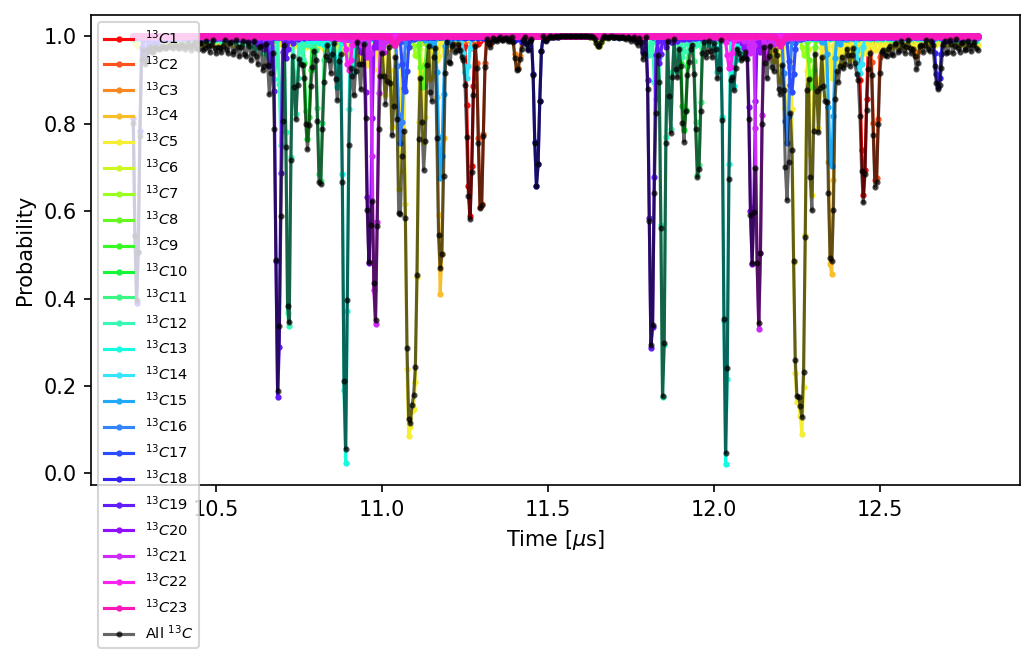

In [11]:
%matplotlib inline
start = 10.25e-3 # in ms
end = 12.8e-3
duration = end-start # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)


plt.figure(dpi=150, figsize=(7,7/1.61803398875))
All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=1, s0=0)
        Ang_0.append(0.5-0.5*sigma_z)
    plt.plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)
    
plt.plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend(fontsize=7,loc=2)
plt.tight_layout()
plt.show()
# plt.savefig('DD_all_64pulse_color.png',dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)
 

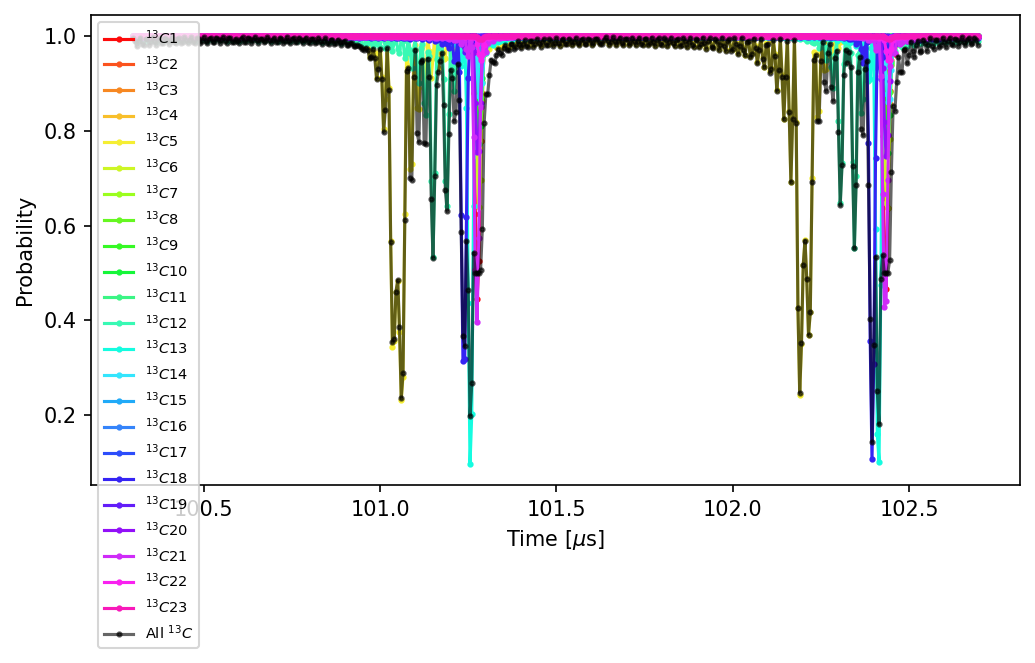

In [12]:
start = 100.3e-3 # in ms
duration = 2.4e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)


plt.figure(dpi=150, figsize=(7,7/1.61803398875))
All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=0.5, s0=-0.5)
        Ang_0.append(0.5-0.5*sigma_z)
    plt.plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)
    
plt.plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.legend(fontsize=7,loc=2)
plt.tight_layout()
# plt.savefig('DD_all_64pulse_color_half.png',dpi=150)
# plt.savefig('DD_all_64pulse.png',dpi=150)

# Fisher simulation for DD spin one
parameters for plot 2 of the paper: For both DD in spin 1 and 1/2
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1500
Taus = np.linspace(start,end, steps) # in ms
N_pi = 254 # number of pi pulses
s1, s0 = 1, 0
eps=0.01

In [13]:
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1000
Taus = np.linspace(start,end, steps) # in ms
N_pi = 16 # number of pi pulses
s1, s0 = 1, 0
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_dd_one_list =[]
for N_pi in [16, 32, 64, 128, 256]:
    Fisher_tau = np.zeros([len(A),len(A)])
    Fisher_dd_one = np.zeros([len(A),len(A)])
    for tau in tqdm(Taus):
        sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=s1, s0=s0)
        p = 0.5-0.5*sigma_z
        for i in range(len(A)):
            Azzp = Azz.copy()
            Azxp = Azx.copy()
            if i<23: Azzp[i] = Azz[i]+eps
            else:    Azxp[i-23] = Azx[i-23]+eps
            Di=(anal_DD_general(fL,Azzp,Azxp,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1, s0=s0))/eps
            
            for j in range(len(A)):
                Azzq = Azz.copy()
                Azxq = Azx.copy()
                if j<23: Azzq[j] = Azz[j]+eps
                else:    Azxq[j-23] = Azx[j-23]+eps
                Dj=(anal_DD_general(fL,Azzq,Azxq,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1,s0=s0))/eps
                Fisher_tau[i][j] = np.abs(1/(p *(1-p)) * Di* Dj)
        Fisher_dd_one += Fisher_tau
    Fisher_dd_one_list.append(Fisher_dd_one)

print(np.min(Fisher_dd_one), np.max(Fisher_dd_one))

100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]

0.00011687945205798088 164485.442730637


Text(0.5, 1.0, 'DD for spin 1')

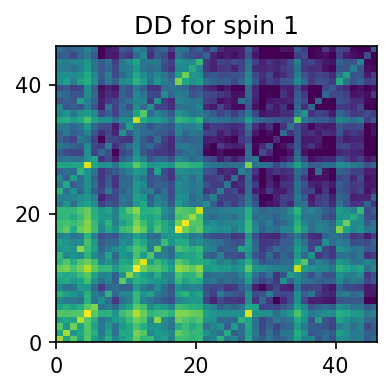

In [104]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
Fisher = np.array(Fisher_dd_one_list[1])
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher), np.max(Fisher))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-3,vmax=1e3)
im = plt.pcolormesh(Fisher, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher.svg',dpi=150)
plt.title('DD for spin 1')

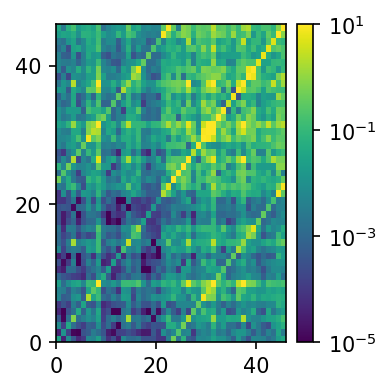

array([[3.07855302e-02, 3.70990627e-05, 7.35762399e-03, ...,
        2.77313317e-03, 1.99261319e-02, 3.92599418e-02],
       [3.70990627e-05, 1.20406752e-02, 1.46365557e-04, ...,
        1.60271878e-03, 3.29883640e-02, 2.96528152e-03],
       [7.35762399e-03, 1.46365557e-04, 4.05823205e-02, ...,
        1.28615975e-02, 2.91943254e-02, 6.59340067e-02],
       ...,
       [2.77313317e-03, 1.60271878e-03, 1.28615975e-02, ...,
        4.74338592e+00, 1.07403189e-01, 7.38175658e-02],
       [1.99261319e-02, 3.29883640e-02, 2.91943254e-02, ...,
        1.07403189e-01, 8.63069139e+01, 7.96874118e-01],
       [3.92599418e-02, 2.96528152e-03, 6.59340067e-02, ...,
        7.38175658e-02, 7.96874118e-01, 4.29503978e+01]])

In [105]:
Inv_Fisher_dd_one = np.linalg.inv(Fisher)
cov_dd_one = Inv_Fisher_dd_one #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_dd_one)), np.max(np.abs(cov_dd_one)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e1)
im = plt.pcolormesh(np.abs(cov_dd_one), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
np.min(np.abs(cov_dd_one)), np.max(np.abs(cov_dd_one))
plt.show()
abs(cov_dd_one)

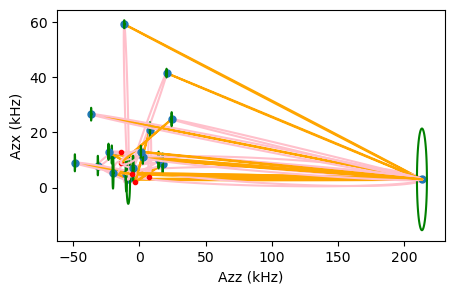

In [114]:
t = np.linspace(0, 2*np.pi, 100)
Fisher = np.array(Fisher_dd_one_list[1])
Inv_Fisher_dd_one = np.linalg.inv(Fisher)
cov_dd_one = Inv_Fisher_dd_one #*1/steps
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_one[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='pink')
        
        ax.plot(x1, y1, 'o', markersize=5, color='C0')
        ax.plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax.plot(x1, y1, 'o', markersize=3, color='red')

plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
# plt.xlim([-50,50])
plt.show()

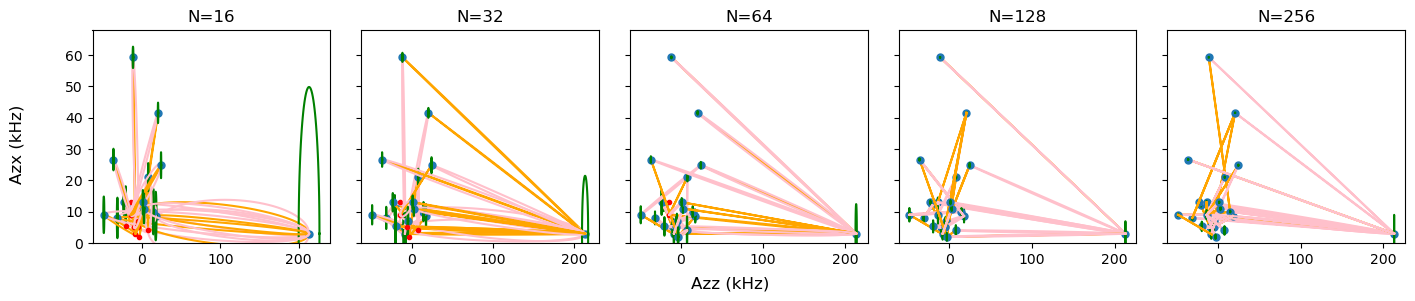

In [113]:
t = np.linspace(0, 2*np.pi, 100)
N_pi=[16,32,64,128,256]
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for n in range(5):
    Fisher = np.array(Fisher_dd_one_list[n])
    Inv_Fisher_dd_one = np.linalg.inv(Fisher)
    cov_dd_one = Inv_Fisher_dd_one #*1/steps
    for i in range(len(Azz)):
        x1 = Azz[i]     #x-position of the center
        X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
        y1 = Azx[i]    #y-position of the center
        Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
        Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
        Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
        if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
            c_max, d_max, jc, jd = 0, 0, 0, 0
            for j in range(len(Azz)): # let's find the most correlated nuclear spin    
                if j!=i:
                    x2 = Azz[j]     #x-position of the center
                    y2 = Azx[j]    #y-position of the center
                    Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
                    Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
                    c = np.sqrt(np.abs(cov_dd_one[i,j]))
                    if c>c_max: c_max, jc = c, j
                    d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
                    if d>d_max: d_max, jd= d, j
            x2, y2 = Azz[jc], Azx[jc]
            U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            ax[n].plot(U,V, color='orange')
            x2, y2 = Azz[jd], Azx[jd]
            U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            ax[n].plot(U,V, color='pink')
            
            ax[n].plot(x1, y1, 'o', markersize=5, color='C0')
            ax[n].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
            ax[n].set_title('N={:}'.format(N_pi[n]))
        else:
            ax[n].plot(x1, y1, 'o', markersize=3, color='red')

fig.subplots_adjust(hspace=0.25,bottom=0.17, left = 0.075, wspace = 0.13, right = 0.95)
fig.supxlabel("Azz (kHz)")
fig.supylabel('Azx (kHz)')
plt.ylim(ymin=0)
plt.show()

# Fisher simulation for DD spin one half

In [16]:
start = 1e-3 # in ms
end = 100e-3 # in ms
steps = 1000
Taus = np.linspace(start,end, steps) # in ms
N_pi = 16 # number of pi pulses
s1, s0 = 0.5, -0.5
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_dd_half = np.zeros([len(A),len(A)])

for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=s1, s0=s0)
    p = 0.5-0.5*sigma_z
    for i in range(len(A)):
        Azzp = Azz.copy()
        Azxp = Azx.copy()
        if i<23: Azzp[i] = Azz[i]+eps
        else:    Azxp[i-23] = Azx[i-23]+eps
        Di=(anal_DD_general(fL,Azzp,Azxp,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1, s0=s0))/eps
        
        for j in range(len(A)):
            Azzq = Azz.copy()
            Azxq = Azx.copy()
            if j<23: Azzq[j] = Azz[j]+eps
            else:    Azxq[j-23] = Azx[j-23]+eps
            Dj=(anal_DD_general(fL,Azzq,Azxq,tau,N_pi, s1=s1,s0=s0)-anal_DD_general(fL,Azz,Azx,tau,N_pi, s1=s1,s0=s0))/eps
            Fisher_tau[i][j] = np.abs(1/(p *(1-p)) * Di* Dj)
    Fisher_dd_half += Fisher_tau

print(np.min(Fisher_dd_half), np.max(Fisher_dd_half))

100%|██████████| 1000/1000 [04:42<00:00,  3.55it/s]

2.03755430969422e-05 7.456800572447068


In [ ]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher_dd_half), np.max(Fisher_dd_half))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# norm = colors.LogNorm(vmin=1e-3,vmax=1e5)
norm = colors.LogNorm(vmin=1e-2,vmax=1e5)
im = plt.pcolormesh(Fisher_dd_half, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_dd_one.svg',dpi=150)
plt.title('DD for spin 1/2')


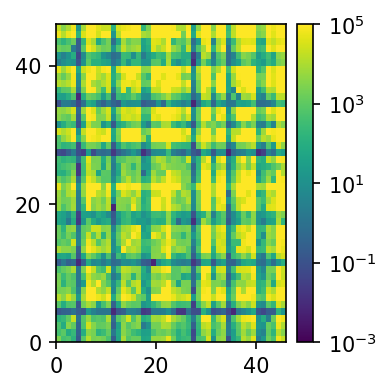

(0.007104470055529619, 176349955.2885201)

In [20]:
Inv_Fisher_dd_half = np.linalg.inv(Fisher_dd_half)
cov_dd_half = Inv_Fisher_dd_half #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_dd_half)), np.max(np.abs(cov_dd_half)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-3,vmax=1e5)
im = plt.pcolormesh(np.abs(cov_dd_half), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
plt.show()
np.min(np.abs(cov_dd_half)), np.max(np.abs(cov_dd_half))


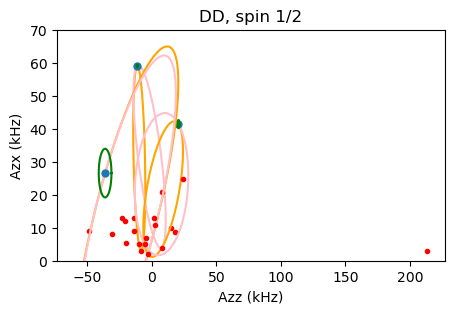

In [112]:
t = np.linspace(0, 2*np.pi, 100)
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_dd_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_half[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_half[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_half[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_dd_half[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='pink')
        
        ax.plot(x1, y1, 'o', markersize=5, color='C0')
        ax.plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax.plot(x1, y1, 'o', markersize=3, color='red')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
plt.title('DD, spin 1/2')
plt.ylim(ymin=0)
plt.show()

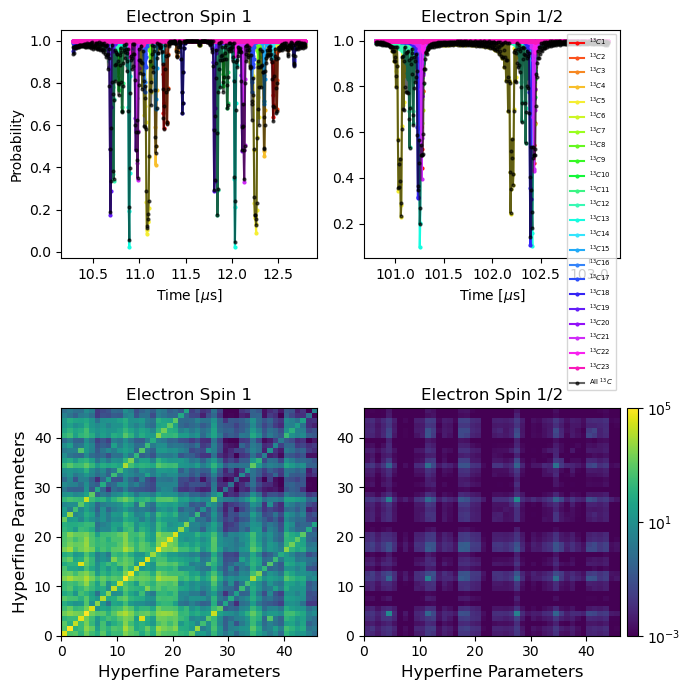

In [34]:
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(7,7), constrained_layout=False)

start = 10.28e-3 # in ms
end = 12.8e-3
duration = end-start # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

All = []
for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=1, s0=0)
        Ang_0.append(0.5-0.5*sigma_z)
    ax[0,0].plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0)
    All.append(0.5-0.5*sigma_z)
    
ax[0,0].plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')
ax[0,0].set_xlabel("Time [$\mu$s]")
ax[0,0].set_ylabel('Probability')
ax[0,0].set_title('Electron Spin 1')
# ax[0].legend(fontsize=7,loc=2)
#####################################################################################################
start = 100.8e-3 # in ms
duration = 2.4e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

All = []

for i, value in enumerate(Azz):
    Ang_0 = []
    for tau in Taus: 
        sigma_z = anal_DD_general(fL, Azz[i], Azx[i], tau, N_pi, s1=0.5, s0=-0.5)
        Ang_0.append(0.5-0.5*sigma_z)
    ax[0,1].plot(Taus*1000, Ang_0, '-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

for tau in Taus:
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    All.append(0.5-0.5*sigma_z)
    
ax[0,1].plot(Taus*1000, All, '-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

ax[0,1].set_xlabel("Time [$\mu$s]")
# ax[0,1].set_ylabel('Probability')
ax[0,1].legend(fontsize=5,loc=1)
ax[0,1].set_title('Electron Spin 1/2')
#####################################################################################################
levels = MaxNLocator(nbins=50).tick_values(np.min(Fisher_dd_one), np.max(Fisher_dd_one))
cmap = plt.get_cmap('PiYG')
norm = colors.LogNorm(vmin=1e-3,vmax=1e5)
im = ax[1,0].pcolormesh(Fisher_dd_one, norm=norm, cmap='viridis', rasterized=True)
ax[1,0].set_title('Electron Spin 1')
# cb=fig.colorbar(im, ax=ax[1,0],shrink=1)
# cb.set_ticks([1e-3, 1e1, 1e5]) # set ticks of your format
ax[1,0].set_xlabel('Hyperfine Parameters', fontsize=12)
ax[1,0].set_ylabel('Hyperfine Parameters', fontsize =12)
# ax[1,0].set_xticks([0, 20, 40])
# ax[1,0].set_yticks([0, 20, 40])
#####################################################################################################
im = ax[1,1].pcolormesh(Fisher_dd_half, norm=norm, cmap='viridis', rasterized=True)
ax[1,1].set_xlabel('Hyperfine Parameters', fontsize=12)
ax[1,1].set_title('Electron Spin 1/2')
cax = ax[1,1].inset_axes([ax[1,1].get_position().x1+0.13, 0, 0.04, 1])
cb = fig.colorbar(im, cax=cax)
cb.set_ticks([1e-3, 1e1, 1e5]) # set ticks of your format

# for n, axs in enumerate(ax.flat):
#     axs.text(-0.1, 1.1, string.ascii_lowercase[n]+'.', transform=axs.transAxes, size=15, weight='bold')

fig.tight_layout()
# fig.savefig('dd_compare2.pdf',dpi=300)

# 5pESEEM

In [35]:
def anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome_a = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome_b = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome_a, (OmeL+s0*Azz)/Ome_a
    nx, nz = s1*Azx/Ome_b, (OmeL+s1*Azz)/Ome_b
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome_a/Ome_b
    q = (s1-s0)*OmeL*Azx/Ome_a/Ome_b
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome_a/Ome_b
    

    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(s0*Azx, OmeL+s0*Azz)     ## specific for spin 1/2
    Eta_b = np.arctan2(s1*Azx, OmeL+s1*Azz)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = 0.25*(np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4))
    return signal

def eseem(fL, Azz, Azx, tau1, tau2, tc, s1=1, s0=-1): ## Azz and Azx are np.array
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    #p = Azx*np.sqrt(s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz))/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau1/2)*cos(Ome1*tau1/2)-dot *sin(Ome0*tau1/2)*sin(Ome1*tau1/2))
    n_V0 = np.array([cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mx +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nx,
                     -sin(Ome1*tau1/2)*sin(Ome0*tau1/2)*q,
                    cos(Ome1*tau1/2)*sin(Ome0*tau1/2)*mz +cos(Ome0*tau1/2)*sin(Ome1*tau1/2)*nz])
    n_V0 /=np.sqrt(np.sum(n_V0*n_V0, axis=0))
        
    ang_W0 = np.arccos(cos(Ome0*tau2/2)*cos(Ome1*tau2/2)-dot *sin(Ome0*tau2/2)*sin(Ome1*tau2/2))
    n_W0 = np.array([cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mx +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nx,
                     -sin(Ome1*tau2/2)*sin(Ome0*tau2/2)*q,
                    cos(Ome1*tau2/2)*sin(Ome0*tau2/2)*mz +cos(Ome0*tau2/2)*sin(Ome1*tau2/2)*nz])
    n_W0 /=np.sqrt(np.sum(n_W0*n_W0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]])
    F0 = np.array([Ome0*tc/2, mx, np.zeros_like(Azz, dtype=float), mz])
    F1 = np.array([Ome1*tc/2, nx, np.zeros_like(Azz, dtype=float), nz])    
    W0 = np.array([ang_W0, n_W0[0], n_W0[1], n_W0[2]])
    W1 = np.array([ang_W0, n_W0[0], -n_W0[1], n_W0[2]])
    
    V0V1d= mulVec(V0, V1d)
    W0F0 = mulVec(W0, F0)
    W0F1 = mulVec(W0, F1)
    W1F0 = mulVec(W1, F0)
    W1F1 = mulVec(W1, F1)
    
    W0F0V0V1dF0dW1d = np.prod(cos(mulAng(mulVec(W0F0, V0V1d), np.array([W1F0[0], -W1F0[1], -W1F0[2], -W1F0[3]]))))
    W1F0V0V1dF0dW0d = np.prod(cos(mulAng(mulVec(W1F0, V0V1d), np.array([W0F0[0], -W0F0[1], -W0F0[2], -W0F0[3]]))))
    W0F1V0V1dF1dW1d = np.prod(cos(mulAng(mulVec(W0F1, V0V1d), np.array([W1F1[0], -W1F1[1], -W1F1[2], -W1F1[3]]))))
    W1F1V0V1dF1dW0d = np.prod(cos(mulAng(mulVec(W1F1, V0V1d), np.array([W0F1[0], -W0F1[1], -W0F1[2], -W0F1[3]])))) 
    return -0.25*(W1F1V0V1dF1dW0d - W0F1V0V1dF1dW1d + W1F0V0V1dF0dW0d - W0F0V0V1dF0dW1d)


100%|██████████| 1500/1500 [00:01<00:00, 1139.18it/s]


Text(0, 0.5, 'FFT of signal (kHz)')

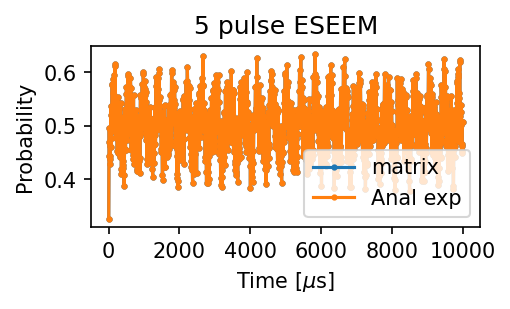

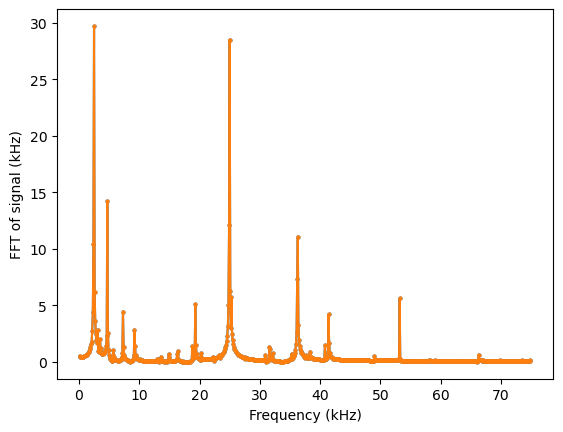

In [70]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 1500
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
#N_pi = 64 # number of pi pulses
N_meas = int(1e4)

tau1, tau2 = 0.5/440, 0.5/440

Signal = []
Signal_anal = []
for tc in tqdm(Tc):
    sigma_z = eseem(fL, Azz, Azx, tau1, tau2, tc, s1=-1, s0=1)
    Signal.append(sigma_z)
    sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=-1, s0=1)
    Signal_anal.append(sigma_z)
Signal = np.array(Signal)
Signal_anal = np.array(Signal_anal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Tc*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.plot(Tc*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('5 pulse ESEEM')
plt.legend()
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
FFT_p = np.abs(np.fft.rfft(p))[1:int(steps/2)]
FFT_p_anal = np.abs(np.fft.rfft(p_anal))[1:int(steps/2)]
plt.figure()
plt.plot(freqs, FFT_p, '-o',ms=2)
plt.plot(freqs, FFT_p_anal, '-o',ms=2)
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT of signal (kHz)')

# Fisher information 5pESEEM spin 1

In [83]:
start = 1e-3 # in ms
duration = 1000 # in ms
steps = 1000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
s1, s0 = 1, -1
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_one = np.zeros([len(A),len(A)])
tau1 = tau2 = 0.5/440

def PSD(fL, Azz, Azx, tau1, tau2, Tc, s1=s1, s0=s0):
    Sigma_z = []
    for tc in Tc:
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=s1, s0=s0)
        Sigma_z.append(sigma_z)
    Sigma_z = np.array(Sigma_z)
    pp = 0.5-0.5*Sigma_z # probability to be in the initial state (bright state)
    FFT_pp = np.abs(np.fft.rfft(pp))[1:int(steps/2)]
    return FFT_pp**2/np.sum(FFT_pp**2)

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
p = PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0)
for i in tqdm(range(len(A))):
    Azzp = Azz.copy()
    Azxp = Azx.copy()
    if i<23: Azzp[i] = Azz[i]+eps
    else:    Azxp[i-23] = Azx[i-23]+eps
    Di=(PSD(fL,Azzp,Azxp,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps

    for j in range(len(A)):
        Azzq = Azz.copy()
        Azxq = Azx.copy()
        if j<23: Azzq[j] = Azz[j]+eps
        else:    Azxq[j-23] = Azx[j-23]+eps
        Dj=(PSD(fL,Azzq,Azxq,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps
#         Fisher_tau[i][j] = 1/p * Di* Dj
        Fisher_one[i][j] = np.sum(np.abs(1/p * Di* Dj))
# Fisher += Fisher_tau
print(np.min(Fisher_one), np.max(Fisher_one))

100%|██████████| 46/46 [17:23<00:00, 22.69s/it]

2.194425412254606e-05 5550107.711344864


([<matplotlib.axis.YTick at 0x1938acdeb50>,
 [Text(0, 0, '0'), Text(0, 20, '20'), Text(0, 40, '40')])

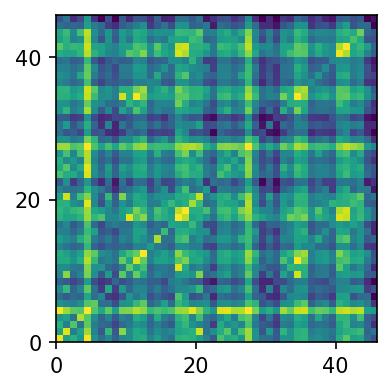

In [84]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
# plt.pcolormesh(Fisher_eseem_one, norm=norm, cmap='viridis', rasterized=True)
levels = MaxNLocator(nbins=100).tick_values(np.min(Fisher_one), np.max(Fisher_one))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-4,vmax=1e3)
im = plt.pcolormesh(Fisher_one, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12) 
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_eseem_one.svg',dpi=150)

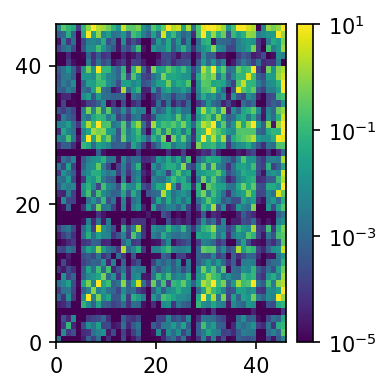

In [85]:
Inv_Fisher_eseem_one= np.linalg.inv(Fisher_one)
cov_eseem_one = Inv_Fisher_eseem_one #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_eseem_one)), np.max(np.abs(cov_eseem_one)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e1)
im = plt.pcolormesh(np.abs(cov_eseem_one), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
np.min(np.abs(cov_eseem_one)), np.max(np.abs(cov_eseem_one))
plt.show()

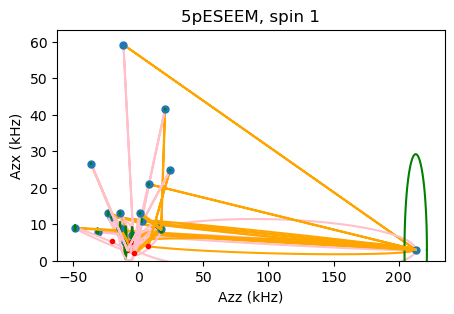

In [111]:
# np.min(Azz), np.max(Azz)
# x_Azz = np.linspace(-50, 250, 3000)
# y_Azx = np.linspace(0, 70, 1500)


t = np.linspace(0, 2*np.pi, 100)
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_eseem_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_eseem_one[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_eseem_one[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_eseem_one[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_eseem_one[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='pink')
        
        ax.plot(x1, y1, 'o', markersize=5, color='C0')
        ax.plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax.plot(x1, y1, 'o', markersize=3, color='red')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
plt.title('5pESEEM, spin 1')
plt.ylim(ymin=0)
plt.show()

# 5pESEEM spin 1/2

In [90]:
start = 1e-3 # in ms
duration = 1000 # in ms
steps = 1000
sample_rate = steps/duration # in kHz
Tc = np.linspace(start,start+duration, steps) # in ms
s1, s0 = 0.5, -0.5
eps=0.01

A = np.concatenate((Azz, Azx))
Fisher_tau = np.zeros([len(A),len(A)])
Fisher_onehalf = np.zeros([len(A),len(A)])
tau1 = tau2 = 0.5/440

def PSD(fL, Azz, Azx, tau1, tau2, Tc, s1=s1, s0=s0):
    Sigma_z = []
    for tc in Tc:
        sigma_z = anal_eseem(fL, Azz, Azx, tau1, tau2, tc, s1=s1, s0=s0)
        Sigma_z.append(sigma_z)
    Sigma_z = np.array(Sigma_z)
    pp = 0.5-0.5*Sigma_z # probability to be in the initial state (bright state)
    FFT_pp = np.abs(np.fft.rfft(pp))[1:int(steps/2)]
    return FFT_pp**2/np.sum(FFT_pp**2)

freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
p = PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0)
for i in tqdm(range(len(A))):
    Azzp = Azz.copy()
    Azxp = Azx.copy()
    if i<23: Azzp[i] = Azz[i]+eps
    else:    Azxp[i-23] = Azx[i-23]+eps
    Di=(PSD(fL,Azzp,Azxp,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps

    for j in range(len(A)):
        Azzq = Azz.copy()
        Azxq = Azx.copy()
        if j<23: Azzq[j] = Azz[j]+eps
        else:    Azxq[j-23] = Azx[j-23]+eps
        Dj=(PSD(fL,Azzq,Azxq,tau1,tau2,Tc, s1=s1, s0=s0)-PSD(fL,Azz,Azx,tau1,tau2,Tc, s1=s1, s0=s0))/eps
#         Fisher_tau[i][j] = 1/p * Di* Dj
        Fisher_onehalf[i][j] = np.sum(np.abs(1/p * Di* Dj))
# Fisher += Fisher_tau
print(np.min(Fisher_onehalf), np.max(Fisher_onehalf))

100%|██████████| 46/46 [16:19<00:00, 21.28s/it]

2.9433612838821945e-06 1569351.3728818106


([<matplotlib.axis.YTick at 0x1938b0e7690>,
 [Text(0, 0, '0'), Text(0, 20, '20'), Text(0, 40, '40')])

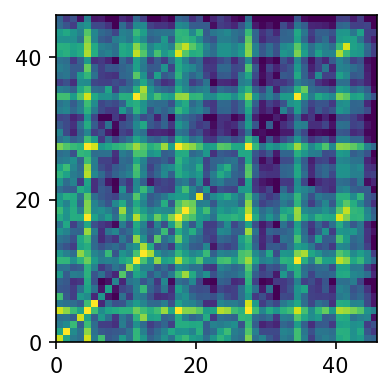

In [91]:
# plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
# plt.pcolormesh(Fisher_eseem_one, norm=norm, cmap='viridis', rasterized=True)
levels = MaxNLocator(nbins=100).tick_values(np.min(Fisher_onehalf), np.max(Fisher_onehalf))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-4,vmax=1e3)
im = plt.pcolormesh(Fisher_onehalf, norm=norm, cmap='viridis', rasterized=True)
# cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12) 
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
# plt.tight_layout()
# plt.savefig('Fisher_eseem_one.svg',dpi=150)


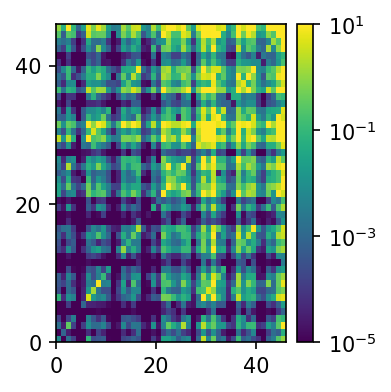

In [93]:
Inv_Fisher_eseem_half= np.linalg.inv(Fisher_onehalf)
cov_eseem_half = Inv_Fisher_eseem_half #*1/steps
plt.figure(dpi=150, figsize=(2.5,2.5), constrained_layout=True)
levels = MaxNLocator(nbins=50).tick_values(np.min(np.abs(cov_eseem_half)), np.max(np.abs(cov_eseem_half)))
cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
norm = colors.LogNorm(vmin=1e-5,vmax=1e1)
im = plt.pcolormesh(np.abs(cov_eseem_half), norm=norm, cmap='viridis', rasterized=True)
cb = plt.colorbar(im)
# cb.set_ticks(np.arange(62,93,5)) # set ticks of your format
#plt.title('Distinction Fidelity Orange')
# plt.xlabel('Power (uW)', fontsize=12)
# plt.ylabel('Readout Time (ms)', fontsize =12)
plt.xticks([0, 20, 40])
plt.yticks([0, 20, 40])
np.min(np.abs(cov_eseem_half)), np.max(np.abs(cov_eseem_half))
plt.show()

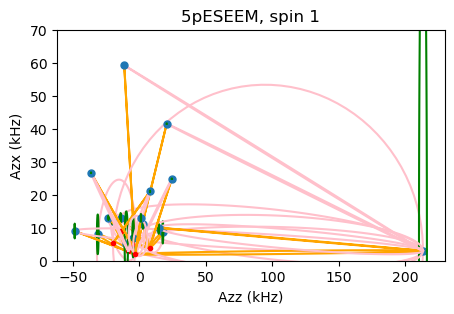

In [115]:
# np.min(Azz), np.max(Azz)
# x_Azz = np.linspace(-50, 250, 3000)
# y_Azx = np.linspace(0, 70, 1500)


t = np.linspace(0, 2*np.pi, 100)
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_eseem_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_eseem_half[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_eseem_half[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_eseem_half[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_eseem_half[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t)
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax.plot(U,V, color='pink')
        
        ax.plot(x1, y1, 'o', markersize=5, color='C0')
        ax.plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax.plot(x1, y1, 'o', markersize=3, color='red')
plt.xlabel("Azz (kHz)")
plt.ylabel('Azx (kHz)')
plt.title('5pESEEM, spin 1')
plt.ylim(ymin=0, ymax=70)
plt.show()

# Saving cov matrices in csv file

In [145]:
np.savetxt('cov_dd_one.csv',cov_dd_one, delimiter=",")

np.savetxt('cov_dd_half.csv',cov_dd_half, delimiter=",")

np.savetxt('cov_eseem_one.csv',cov_eseem_one, delimiter=",")

np.savetxt('cov_eseem_half.csv',cov_eseem_half, delimiter=",")



arr = np.array(Fisher_dd_one_list)
arr_reshaped = arr.reshape(arr.shape[0], -1) # Reshape the 3D array to 2D
np.savetxt("Fisher_dd_one_list.csv", arr_reshaped, delimiter=",") # Save the 2D array to a CSV file

# Loading cov matrices from the saved csv file

In [10]:
cov_dd_one = np.loadtxt("cov_dd_one.csv", delimiter=",") # Load the 2D array from the CSV file

cov_dd_half = np.loadtxt("cov_dd_half.csv", delimiter=",") # Load the 2D array from the CSV file

cov_eseem_one = np.loadtxt("cov_eseem_one.csv", delimiter=",") # Load the 2D array from the CSV file

cov_eseem_half = np.loadtxt("cov_eseem_half.csv", delimiter=",") # Load the 2D array from the CSV file


loaded_arr = np.loadtxt("Fisher_dd_one_list.csv", delimiter=",") # Load the 2D array from the CSV file
Fisher_dd_one_list = loaded_arr.reshape((5, 46, 46)) # Reshape the 2D array back to its original 3D shape



In [11]:
%matplotlib inline

# combined plots

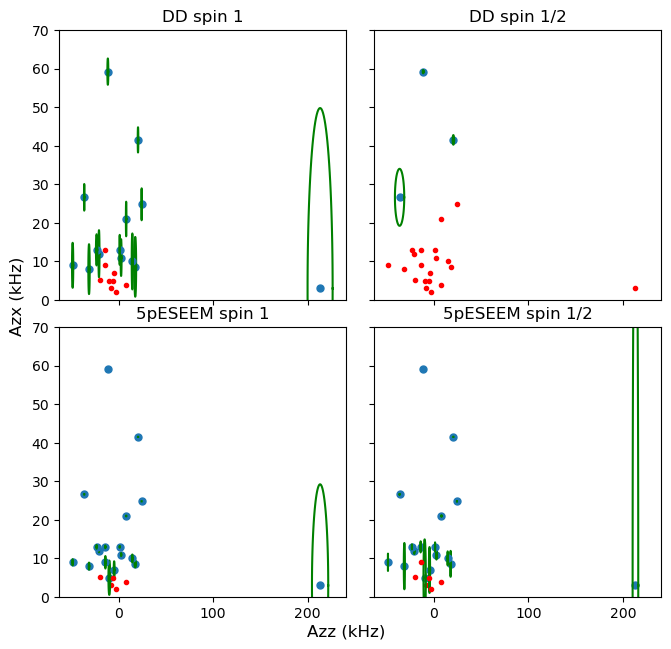

In [12]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex= True, figsize=(7,7), constrained_layout=False)
t = np.linspace(0, 2*np.pi, 100)
#111111111111111111111111111111111111###################################################################################################    
Fisher = np.array(Fisher_dd_one_list[0])
Inv_Fisher_dd_one = np.linalg.inv(Fisher)
cov_dd_one = Inv_Fisher_dd_one #*1/steps
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        # c_max, d_max, jc, jd = 0, 0, 0, 0
        # for j in range(len(Azz)): # let's find the most correlated nuclear spin    
        #     if j!=i:
        #         x2 = Azz[j]     #x-position of the center
        #         y2 = Azx[j]    #y-position of the center
        #         Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
        #         Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
        #         c = np.sqrt(np.abs(cov_dd_one[i,j]))
        #         if c>c_max: c_max, jc = c, j
        #         d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
        #         if d>d_max: d_max, jd= d, j
        # x2, y2 = Azz[jc], Azx[jc]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[0,0].plot(U,V, color='orange')
        # x2, y2 = Azz[jd], Azx[jd]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[0,0].plot(U,V, color='pink')
        
        ax[0,0].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[0,0].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[0,0].plot(x1, y1, 'o', markersize=3, color='red')

#2222222222222222222222222222222222222####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_dd_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        # c_max, d_max, jc, jd = 0, 0, 0, 0
        # for j in range(len(Azz)): # let's find the most correlated nuclear spin    
        #     if j!=i:
        #         x2 = Azz[j]     #x-position of the center
        #         y2 = Azx[j]    #y-position of the center
        #         Rx2 = np.sqrt(np.abs(cov_dd_half[j,j]))     #radius on the x-axis
        #         Ry2 = np.sqrt(np.abs(cov_dd_half[j+23,j+23]))   #radius on the y-axis
        #         c = np.sqrt(np.abs(cov_dd_half[i,j]))
        #         if c>c_max: c_max, jc = c, j
        #         d = np.sqrt(np.abs(cov_dd_half[i+23,j+23]))
        #         if d>d_max: d_max, jd= d, j
        # x2, y2 = Azz[jc], Azx[jc]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[0,1].plot(U,V, color='orange')
        # x2, y2 = Azz[jd], Azx[jd]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[0,1].plot(U,V, color='pink')
        
        ax[0,1].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[0,1].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[0,1].plot(x1, y1, 'o', markersize=3, color='red')
#3333333333333333333333333333333333####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_eseem_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        # c_max, d_max, jc, jd = 0, 0, 0, 0
        # for j in range(len(Azz)): # let's find the most correlated nuclear spin    
        #     if j!=i:
        #         x2 = Azz[j]     #x-position of the center
        #         y2 = Azx[j]    #y-position of the center
        #         Rx2 = np.sqrt(np.abs(cov_eseem_one[j,j]))     #radius on the x-axis
        #         Ry2 = np.sqrt(np.abs(cov_eseem_one[j+23,j+23]))   #radius on the y-axis
        #         c = np.sqrt(np.abs(cov_eseem_one[i,j]))
        #         if c>c_max: c_max, jc = c, j
        #         d = np.sqrt(np.abs(cov_eseem_one[i+23,j+23]))
        #         if d>d_max: d_max, jd= d, j
        # x2, y2 = Azz[jc], Azx[jc]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[1,0].plot(U,V, color='orange')
        # x2, y2 = Azz[jd], Azx[jd]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[1,0].plot(U,V, color='pink')
        
        ax[1,0].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[1,0].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[1,0].plot(x1, y1, 'o', markersize=3, color='red')

#444444444444444444444444444444444####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_eseem_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        # c_max, d_max, jc, jd = 0, 0, 0, 0
        # for j in range(len(Azz)): # let's find the most correlated nuclear spin    
        #     if j!=i:
        #         x2 = Azz[j]     #x-position of the center
        #         y2 = Azx[j]    #y-position of the center
        #         Rx2 = np.sqrt(np.abs(cov_eseem_half[j,j]))     #radius on the x-axis
        #         Ry2 = np.sqrt(np.abs(cov_eseem_half[j+23,j+23]))   #radius on the y-axis
        #         c = np.sqrt(np.abs(cov_eseem_half[i,j]))
        #         if c>c_max: c_max, jc = c, j
        #         d = np.sqrt(np.abs(cov_eseem_half[i+23,j+23]))
        #         if d>d_max: d_max, jd= d, j
        # x2, y2 = Azz[jc], Azx[jc]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[1,1].plot(U,V, color='orange')
        # x2, y2 = Azz[jd], Azx[jd]
        # U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        # ax[1,1].plot(U,V, color='pink')
        
        ax[1,1].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[1,1].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[1,1].plot(x1, y1, 'o', markersize=3, color='red')
ax[0,0].set_title('DD spin 1')
ax[0,1].set_title('DD spin 1/2')
ax[1,0].set_title('5pESEEM spin 1')
ax[1,1].set_title('5pESEEM spin 1/2')
fig.subplots_adjust(hspace=0.1,bottom=0.07, left = 0.09, wspace = 0.1, right = 0.95)
fig.supxlabel("Azz (kHz)")
fig.supylabel('Azx (kHz)')
plt.ylim(ymin=0, ymax=70)
plt.show()
# fig.savefig('cov_compare.pdf',dpi=300)

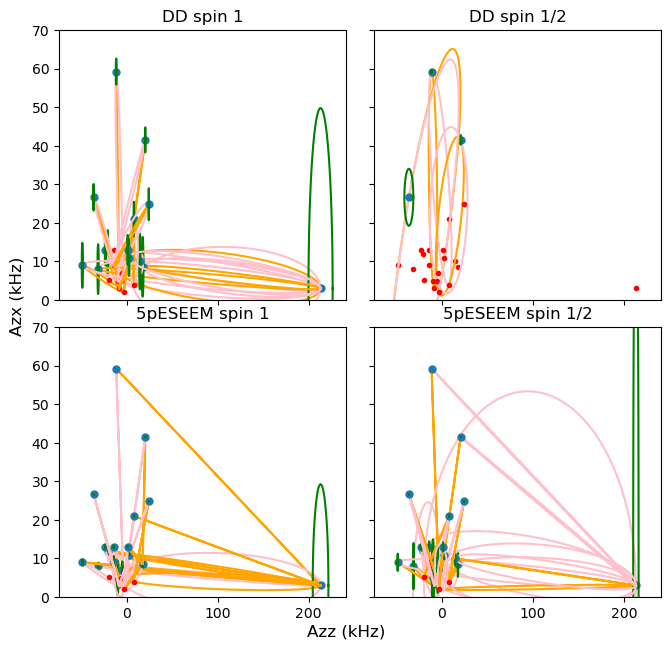

In [149]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex= True, figsize=(7,7), constrained_layout=False)
t = np.linspace(0, 2*np.pi, 100)
#111111111111111111111111111111111111###################################################################################################    
Fisher = np.array(Fisher_dd_one_list[0])
Inv_Fisher_dd_one = np.linalg.inv(Fisher)
cov_dd_one = Inv_Fisher_dd_one #*1/steps
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float))) # neares Azz neighbore
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float))) # neares Azx neighbore
    Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_one[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[0,0].plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[0,0].plot(U,V, color='pink')
        
        ax[0,0].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[0,0].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[0,0].plot(x1, y1, 'o', markersize=3, color='red')

#2222222222222222222222222222222222222####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_dd_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_dd_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_dd_half[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_dd_half[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_dd_half[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_dd_half[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[0,1].plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[0,1].plot(U,V, color='pink')
        
        ax[0,1].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[0,1].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[0,1].plot(x1, y1, 'o', markersize=3, color='red')
#3333333333333333333333333333333333####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float)))
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float)))
    Rx1 = np.sqrt(np.abs(cov_eseem_one[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_one[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_eseem_one[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_eseem_one[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_eseem_one[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_eseem_one[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[1,0].plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[1,0].plot(U,V, color='pink')
        
        ax[1,0].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[1,0].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[1,0].plot(x1, y1, 'o', markersize=3, color='red')

#444444444444444444444444444444444####################################################################################################
for i in range(len(Azz)):
    x1 = Azz[i]     #x-position of the center
    X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float))) # neares Azz neighbore
    y1 = Azx[i]    #y-position of the center
    Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float))) # neares Azx neighbore
    Rx1 = np.sqrt(np.abs(cov_eseem_half[i,i]))     #radius on the x-axis
    Ry1 = np.sqrt(np.abs(cov_eseem_half[i+23,i+23]))   #radius on the y-axis
    if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
        c_max, d_max, jc, jd = 0, 0, 0, 0
        for j in range(len(Azz)): # let's find the most correlated nuclear spin    
            if j!=i:
                x2 = Azz[j]     #x-position of the center
                y2 = Azx[j]    #y-position of the center
                Rx2 = np.sqrt(np.abs(cov_eseem_half[j,j]))     #radius on the x-axis
                Ry2 = np.sqrt(np.abs(cov_eseem_half[j+23,j+23]))   #radius on the y-axis
                c = np.sqrt(np.abs(cov_eseem_half[i,j]))
                if c>c_max: c_max, jc = c, j
                d = np.sqrt(np.abs(cov_eseem_half[i+23,j+23]))
                if d>d_max: d_max, jd= d, j
        x2, y2 = Azz[jc], Azx[jc]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[1,1].plot(U,V, color='orange')
        x2, y2 = Azz[jd], Azx[jd]
        U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
        ax[1,1].plot(U,V, color='pink')
        
        ax[1,1].plot(x1, y1, 'o', markersize=5, color='C0')
        ax[1,1].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
    else:
        ax[1,1].plot(x1, y1, 'o', markersize=3, color='red')
ax[0,0].set_title('DD spin 1')
ax[0,1].set_title('DD spin 1/2')
ax[1,0].set_title('5pESEEM spin 1')
ax[1,1].set_title('5pESEEM spin 1/2')
fig.subplots_adjust(hspace=0.1,bottom=0.07, left = 0.09, wspace = 0.1, right = 0.95)
fig.supxlabel("Azz (kHz)")
fig.supylabel('Azx (kHz)')
plt.ylim(ymin=0, ymax=70)
plt.show()
# fig.savefig('cov_compare.pdf',dpi=300)

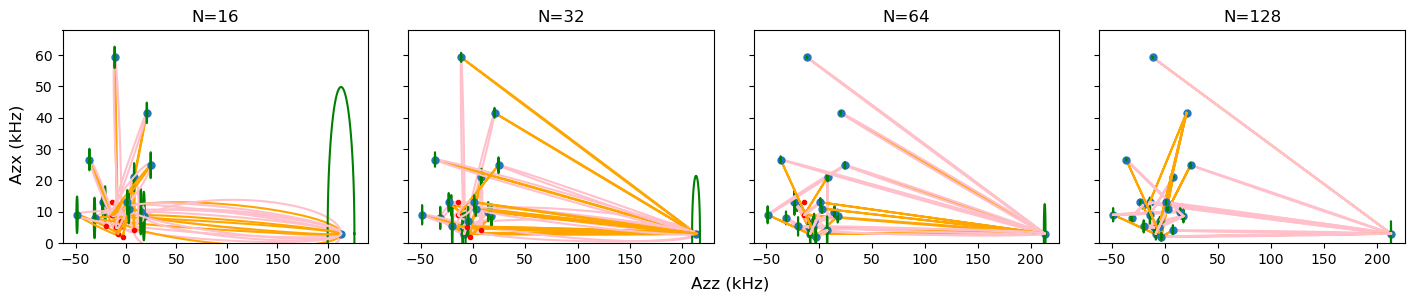

In [20]:
t = np.linspace(0, 2*np.pi, 100)
N_pi=[16,32,64,128]
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for n in range(len(N_pi)):
    Fisher = np.array(Fisher_dd_one_list[n])
    Inv_Fisher_dd_one = np.linalg.inv(Fisher)
    cov_dd_one = Inv_Fisher_dd_one #*1/steps
    for i in range(len(Azz)):
        x1 = Azz[i]     #x-position of the center
        X1 = np.min(np.abs(np.delete(Azz, i) - np.full_like(np.delete(Azz, i), x1, dtype=float))) # neares Azz neighbore
        y1 = Azx[i]    #y-position of the center
        Y1 = np.min(np.abs(np.delete(Azx, i) - np.full_like(np.delete(Azx, i), y1, dtype=float))) # neares Azx neighbore
        Rx1 = np.sqrt(np.abs(cov_dd_one[i,i]))     #radius on the x-axis
        Ry1 = np.sqrt(np.abs(cov_dd_one[i+23,i+23]))   #radius on the y-axis
        if Rx1< min([abs(x1), X1]) or Ry1<min([abs(y1), Y1]):
            c_max, d_max, jc, jd = 0, 0, 0, 0
            for j in range(len(Azz)): # let's find the most correlated nuclear spin    
                if j!=i:
                    x2 = Azz[j]     #x-position of the center
                    y2 = Azx[j]    #y-position of the center
                    Rx2 = np.sqrt(np.abs(cov_dd_one[j,j]))     #radius on the x-axis
                    Ry2 = np.sqrt(np.abs(cov_dd_one[j+23,j+23]))   #radius on the y-axis
                    c = np.sqrt(np.abs(cov_dd_one[i,j]))
                    if c>c_max: c_max, jc = c, j
                    d = np.sqrt(np.abs(cov_dd_one[i+23,j+23]))
                    if d>d_max: d_max, jd= d, j
            x2, y2 = Azz[jc], Azx[jc]
            U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-c_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+c_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            ax[n].plot(U,V, color='orange')
            x2, y2 = Azz[jd], Azx[jd]
            U = (x1+x2)/2 + (x2-x1)/2*np.cos(t)-d_max*(y2-y1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            V = (y1+y2)/2 + (y2-y1)/2*np.cos(t)+d_max*(x2-x1)/np.sqrt((x2-x1)**2+(y2-y1)**2)*np.sin(t) 
            ax[n].plot(U,V, color='pink')
            
            ax[n].plot(x1, y1, 'o', markersize=5, color='C0')
            ax[n].plot(x1+Rx1*np.cos(t) , y1+Ry1*np.sin(t) , color = 'green')
            ax[n].set_title('N={:}'.format(N_pi[n]))
        else:
            ax[n].plot(x1, y1, 'o', markersize=3, color='red')

fig.subplots_adjust(hspace=0.25,bottom=0.17, left = 0.055, wspace = 0.13, right = 0.95)
fig.supxlabel("Azz (kHz)")
fig.supylabel('Azx (kHz)')
plt.ylim(ymin=0)
plt.show()